In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib
import matplotlib.pyplot as plt  # 파이플롯 사용
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')  # 한글코드를 더 선명하게 해주는 조치, 레티나 설정
matplotlib.rc('font', family='AppleGothic') # 폰트 설정
matplotlib.rc('axes', unicode_minus=False) # 마이너스 폰트가 깨지는 경우가 있으므로 조치

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'This pattern has match groups')
warnings.filterwarnings('ignore', 'The iterable function was deprecated in Matplotlib')


In [3]:
df = pd.read_csv("course_page_actions.csv", engine='python')


In [4]:
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


### group 필드 설명
- experiment : 실험군 (새 랜딩페이지)
- control : 대조군 (구 랜딩페이지)

### action 필드 설명
- view : 단순 노출
- enroll : 등록 (conversion)

### CTR : enroll / view

In [5]:
# 대조군(구 랜딩페이지) CTR 실적을 보기 위해 대조군 데이터만 따로 봅니다
#control_df = df.query('group == "control"')
control_df = df.loc[df['group'] == 'control']

# 대조군의 CTR을 연산(enroll / view)하고 변수에 담아줍니다
#control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()
control_ctr = control_df.loc[df['action'] == 'enroll', 'id'].nunique() / control_df.loc[df['action'] == 'view', 'id'].nunique()

# Display click through rate
control_ctr


0.2364438839848676

In [6]:
# 실험군(신 랜딩페이지) CTR 실적을 보기 위해 실험군 데이터만 따로 봅니다
#experiment_df = df.query('group == "experiment"')
experiment_df = df.loc[df['group'] == 'experiment']


# 실험군의 CTR을 연산(enroll / view)하고 변수에 담아줍니다
# experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
experiment_ctr = experiment_df.loc[df['action'] == 'enroll', 'id'].nunique() / experiment_df.loc[df['action'] == 'view', 'id'].nunique()


# Display click through rate
experiment_ctr


0.2668693009118541

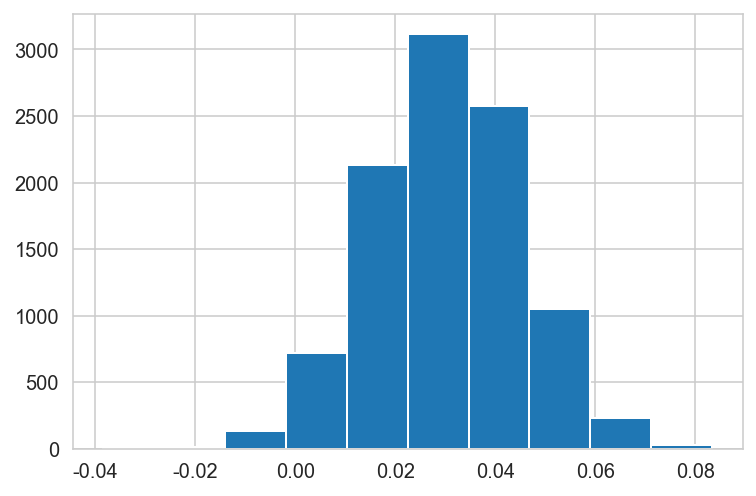

In [7]:


# 실험군과 대조군 간의 ctr 차이 (observed 관찰된 차이)를 obs_diff 변수에 담는다
obs_diff = experiment_ctr - control_ctr

# 하지만 이 차이가 통계적으로 유의미한지 검토하기 위해 부트스트랩 기법을 통해 검정한다.
# 이 말인 즉슨, 둘의 차이들이 랜덤한 표본에서 나왔냐를 검정한다는 것

# Create a sampling distribution of the difference in proportions
# with bootstrapping
boots_diffs = []

size = df.shape[0]
# 부트스트랩을 위해 랜덤하게 df를 섞어주자. sample()을 쓰긴 할거지만 사이즈를 원본 데이터와 같게 한다.
for _ in range(10000):
    bootstrap_sampling = df.sample(size, replace=True)
    
    control_df = bootstrap_sampling.loc[df['group'] == 'control']
    experiment_df = bootstrap_sampling.loc[df['group'] == 'experiment']
    control_ctr = control_df.loc[df['action'] == 'enroll', 'id'].nunique() / control_df.loc[df['action'] == 'view', 'id'].nunique()
    experiment_ctr = experiment_df.loc[df['action'] == 'enroll', 'id'].nunique() / experiment_df.loc[df['action'] == 'view', 'id'].nunique()
    boots_diffs.append(experiment_ctr - control_ctr)

# Convert to numpy array
boots_diffs = np.array(boots_diffs)


# Plot sampling distribution
plt.hist(boots_diffs);

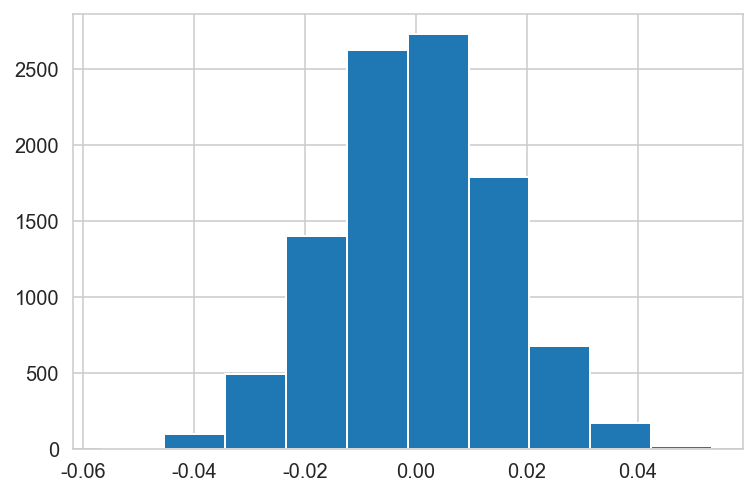

In [10]:
#귀무가설을 기반으로 하는 정규분포를 그립니다. (평균은 0 (차이가 없다), 표준편차는 부트스트랩 표본의 표준편차)
null_values = np.random.normal(0, boots_diffs.std(), boots_diffs.size)

# Plot the null distribution
plt.hist(null_values);

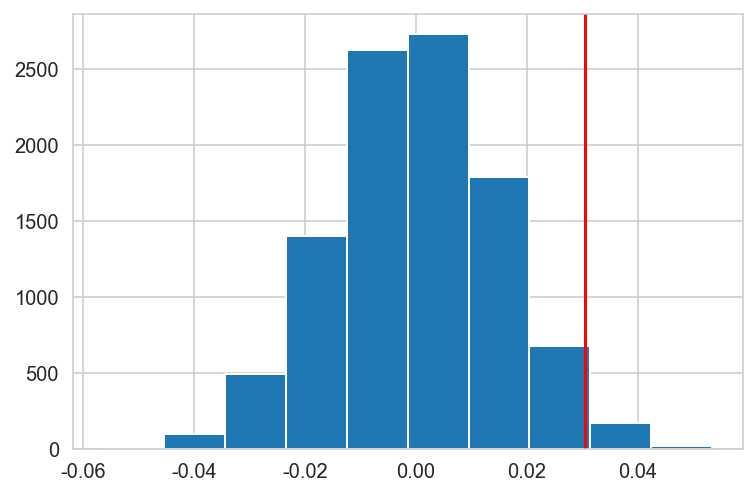

In [11]:
# 맨 처음 구했던 실험군과 대조군의 평균 CTR 차이에 해당하는 값을 빨간 선으로 표시

plt.hist(null_values);
plt.axvline(obs_diff, c='red')

유의수준(p-value)이 0.05 미만 때, 귀무가설(구&신 랜딩페이지의 차이가 없을 것이다)을 기각


따라서, 신 랜딩 페이지의 평균 CTR이 더 높다고 판정 내릴 수 있습니다.   

<br>


- diffs : 같은 옵션으로 부트스트래핑 1만번 해본 차이들 - 여기서 표본의 표본편차 구함

- null_vals : 우연의 일치들 (수많은 CTR 간 차이들) - diffs의 표본편차를 적용해놓았음

- obs_diff : 빨간선 / 내가 AB 테스트한 결과 (CTR 간 차이값 0.030425...)

<br>

**표면해석 ) 내 ab 테스트 결과(CTR 차이)는 꽤 큰 편에 속한다 (우측 끝부분에 있음)**

**해석 2단계 ) normal로 그렸으니 저건 정규분포 곡선이다. 이때 내 ab테스트 결과 부분 이상을 적분한 확률(p)이 0.05보다 작은가?**

→ 작으면 완전 레어한 상황이니 유의미하다고 판정할 수 있다   
<br>

   
귀무가설 : 랜덤한 값 >= 나의 결과물

대립가설(진또배기) : 랜덤한 값 < 나의 결과물
<br>

**p값의 정의 : 귀무가설을 구체화한 기회 모델이 주어졌을 때, 관측된 결과와 같이 특이하거나 더 극단적인 결과를 얻을 확률**

여기서 특이/극단적 결과란 나의 AB테스트 결과 and 그것도바 더 특이(CTR 차이 더 큼)한 값이다


In [13]:
# 적분한 확률을 구해보자
# null_values >= obs_diff(0.03...정도) 라는 표기는 불린인덱스로 true, false 판정만 array로 존나 나옴 - 이거의 .mean()으로 확률을 구함

probability = (null_values >= obs_diff).mean()

print("우연하게 나온 값이 관찰값보다 클 (극단적인) 상황의 확률probability은 :", probability)
print("probability에 퍼센트를 붙여서 표현하면 %.2f 퍼센트인셈"%(probability*100))

print("p-value란 결국 저 probability인 것이고, 5%보다 낮으니 AB 테스트의 현상은 통계적으로도 유의미하다")



우연하게 나온 값이 관찰값보다 클 (극단적인) 상황의 확률probability은 : 0.0219
probability에 퍼센트를 붙여서 표현하면 2.19 퍼센트인셈
p-value란 결국 저 probability인 것이고, 5%보다 낮으니 AB 테스트의 현상은 통계적으로도 유의미하다


아 p값이 0.02라고? 귀무가설 기각 - 그말인 즉슨 새 랜딩페이지의 CTR 차이가 유의미하다고 결론

### 검정력, 효과크기, 표본크기 3종 세트

잠깐, 이 표본 ... 사이즈 괜찮나요?

p값을 구했으니 검정력, 효과크기를 통해 표본크기를 산정해봅니다


### 효과크기에 따른 해석

효과크기가 0보다 크다는 뜻은 실험군의 효과가 실제로 있다는 뜻이고
더 정확히 말하자면 실험군(새 랜딩페이지의 CTR)이 대조군보다 높다는 뜻입니다.

역으로 내가 CTR을 기존의 것보다 새 랜딩페이지가 30% 정도 높게 끌어올리고 싶다면 효과크기를 0.3으로 형성하면 되는 것입니다.

*단, 효과크기가 작은만큼 더 많은 표본이 필요하고 까다롭다는 걸 잊지마세요


In [15]:
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower

import scipy.stats as st  # z-score를 확률로 계산할 때 쓰임

In [23]:
p_value = probability
effect_size = (experiment_ctr - control_ctr) / control_ctr

print("새 랜딩페이지의 p 값은 : %.3f"%(probability))
print("새 랜딩페이지의 효과크기(ES)는 : %.3f"%(effect_size))


새 랜딩페이지의 p 값은 : 0.022
새 랜딩페이지의 효과크기(ES)는 : 0.146


In [24]:
# parameters for the analysis 
effect_size = effect_size
alpha = 0.05 # significance level, p_value
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size,
                                         power = power,
                                         alpha = alpha)

print('AB테스트에 필요한 표본 사이즈는: {0:.1f}개'.format(sample_size))
print('방금 진행한 테스트 표본 사이즈는: {}개'.format(df.shape[0]))
print('따라서 {0:.1f}개 만큼 표본을 늘려서 테스트해야합니다'.format(sample_size - df.shape[0]))



AB테스트에 필요한 표본 사이즈는: 737.6개
방금 진행한 테스트 표본 사이즈는: 4074개
따라서 -3336.4개 만큼 표본을 늘려서 테스트해야합니다


### 효과크기와 표본크기 해석하기

- 효과크기가 0.146이 나왔다는 것은 새 랜딩페이지의 CTR은 구 랜딩페이지 CTR보다 14.6% 더 좋은 것이다.

> 14%의 전환율 상승이 중요하다면 해당 효과 크기에서의 유의성 확보는 매우 중요하다. 반대로 최소한 20%의 전환율 상승이 있어야 실험의 비용을 감당할 수 있는 상황이라면 20%의 효과에 대해서 유의성을 확보하기 위한 노력은 불필요하다.

<br>

실험 크기(n)를 증가시키면 아주 작은 효과 크기에 대해서도 유의성을 확보할 수 있다.   

즉, (미세한 효과크기라도) 없는데 있다고 판단할 오류를 배제할 수 있다.   

하지만 아주 작은 효과 밖에 없다면, 과연 그 효과가 ‘없는데 있다고 판단할 2종 오류’를 범하지 않기 위해 애쓸 필요가 있을까? 그 정도 차이는 있어도 소용 없으니 차라리 다른 실험을 준비하는 편이 낫다.